# Elevations per year

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import DataSetQuery
import datetime
import json
import MalardHelpers
import geopandas as gp
import numpy as np
from shapely.geometry import Point, Polygon
from pandas.io.json import json_normalize
import os
import calendar
import pandas as pd


In [10]:
environmentName = 'DEV'
parentDsName = 'mtngla'
dataSet = 'ReadyData4'
runName='TestRun4-Serial'
region = 'HMA'

#Sets the URL of the Malard ServiceGateway.
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataSet)
bbx = json.loads(bbx)
#Sets the URL of the Malard ServiceGateway.
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

minT = datetime.datetime.utcfromtimestamp(bbx['minTime']/1000) # divide by 1000 because it is in milliseconds
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime']/1000+10000)


In [11]:
stats=query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
print('Columns: ',dfStats.columns)

#create new stats: area and point ratio
dfStats['statistics.points_per_sqkm']=dfStats['statistics.result_total']/dfStats['statistics.glacierMaskArea']

#convert to geodataframe
crs = json.loads(query.getProjection(region))['proj4']

#geometry = [Point(xy) for xy in zip(dfStats['gridCell.minX'], dfStats['gridCell.minY'])]
geometry = []
for idx, line in dfStats.iterrows():
    minX,maxX=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
    minY,maxY=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
    geometry.append(Polygon([(minX,minY), (minX,maxY), (maxX,maxY), (maxX,minY), (minX,minY)]))
geoStats = gp.GeoDataFrame(dfStats, crs=crs, geometry=geometry)
#geoStats=geoStats.dropna()

Columns:  Index(['gridCell.minX', 'gridCell.minY', 'gridCell.size',
       'statistics.afterDebrisMask', 'statistics.afterGlacierMask',
       'statistics.debrisMaskArea', 'statistics.glacierMaskArea',
       'statistics.joined_data', 'statistics.result_avgX',
       'statistics.result_avgY', 'statistics.result_count_2010',
       'statistics.result_count_2011', 'statistics.result_count_2012',
       'statistics.result_count_2013', 'statistics.result_count_2014',
       'statistics.result_count_2015', 'statistics.result_count_2016',
       'statistics.result_count_2017', 'statistics.result_count_2018',
       'statistics.result_offsetX', 'statistics.result_offsetY',
       'statistics.result_srtm', 'statistics.result_tandemx',
       'statistics.result_total', 'statistics.srtm_filtered',
       'statistics.srtm_not_in', 'statistics.tandemX_filtered'],
      dtype='object')


In [12]:
# ADD Elevation
years=[x for x in range(minT.year, maxT.year+1)]

# create empty columns for each year
newColumns = ['statistics.elevation_mean_%s'%year for year in years]
newColumns.append('statistics.elevation_mean')
geoStats = geoStats.reindex(columns=np.append( geoStats.columns.values, newColumns))

for idx, line in geoStats.iterrows():
    min_X,max_X=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
    min_Y,max_Y=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
    file = query.getNetCdfFile(parentDsName,dataSet,min_X,max_X,min_Y,max_Y,minT,maxT)
    df = MalardHelpers.getDataFrameFromNetCDF(file)
    # add mean elevation over all years
    geoStats['statistics.elevation_mean'][idx]=df['elev'].mean()
    for year in years:
        start, end = datetime.datetime(year,1,1,0,0), datetime.datetime(year+1,1,1,0,0)
        start = calendar.timegm(start.utctimetuple())
        end = calendar.timegm(end.utctimetuple())
        geoStats['statistics.elevation_mean_%s'%year][idx]=df.loc[(df.time >= start) & (df.time <end), 'elev'].mean()

/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# HISTOGRAM mean Elevations per year

<IPython.core.display.Javascript object>


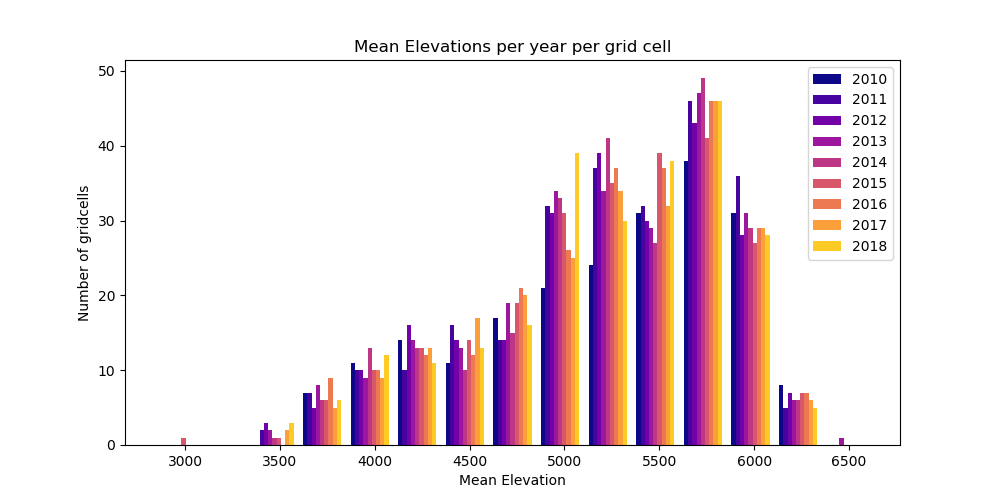

In [13]:
#HISTOGRAM mean Elevations per year
plt.figure(figsize=(10,5))
plt.title('Mean Elevations per year per grid cell')
plt.ylabel('Number of gridcells')
plt.xlabel('Mean Elevation')
bins = 15
NUM_COLORS = 9
cm = plt.get_cmap('plasma')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax=plt.hist([geoStats['statistics.elevation_mean_2010'], geoStats['statistics.elevation_mean_2011'], \
          + geoStats['statistics.elevation_mean_2012'], geoStats['statistics.elevation_mean_2013'], \
          + geoStats['statistics.elevation_mean_2014'], geoStats['statistics.elevation_mean_2015'], \
          + geoStats['statistics.elevation_mean_2016'], geoStats['statistics.elevation_mean_2017'], \
          + geoStats['statistics.elevation_mean_2018']], \
         + bins, label=years, color=colors)


plt.legend(loc='upper right')
plt.show()

# Differences between mean elevation of a gridcell and elevation every year

<IPython.core.display.Javascript object>


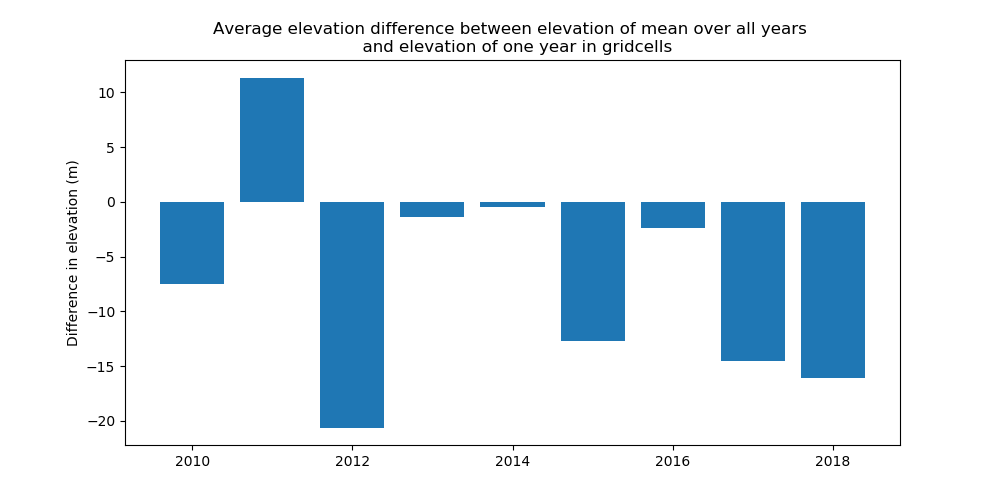

<BarContainer object of 9 artists>

In [14]:
# calculate differences between mean elevation of a gridcell and elevation every year
changesMean=[]
for year in years:
    change = geoStats['statistics.elevation_mean_%s'%year]-geoStats['statistics.elevation_mean']
    changesMean.append(change)

means = [change.mean() for change in changesMean]
plt.figure(figsize=(10,5))
plt.title('Average elevation difference between elevation of mean over all years \n  and elevation of one year in gridcells')
plt.ylabel('Difference in elevation (m)')
plt.bar(years, means)


In [18]:
# Add changes to dataframe
#for year in years:
#    geoStats['statistics.elevation_changes_mean_%s'%year]=changesMean[]


9

# Same displayed for every gridcell

<IPython.core.display.Javascript object>


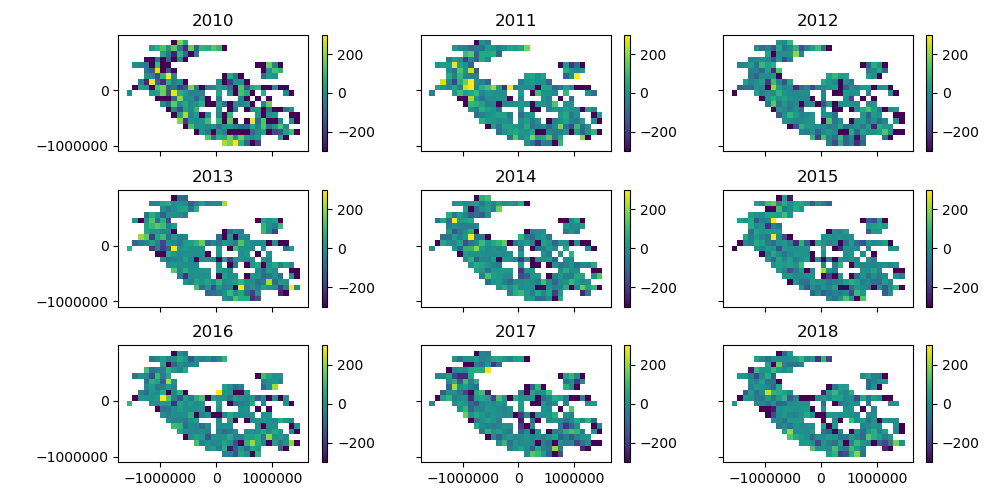

In [25]:
# Difference of elevation between one year and average of every year (per gridcell)
years=[x for x in range(minT.year, maxT.year+1)]
for idx in range(len(years)):
    geoStats['statistics.elevation_mean_difference_%s'%years[idx]]=changesMean[idx]
    
    
# Change in number of points from year to year
vmin = -300
vmax = 300

# Total points per year per grid cell
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True)

geoStats.plot(ax= axs[0][0], column='statistics.elevation_mean_difference_2010', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[0][1], column='statistics.elevation_mean_difference_2011', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[0][2], column='statistics.elevation_mean_difference_2012', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[1][0], column='statistics.elevation_mean_difference_2013', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[1][1], column='statistics.elevation_mean_difference_2014', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[1][2], column='statistics.elevation_mean_difference_2015', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[2][0], column='statistics.elevation_mean_difference_2016', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[2][1], column='statistics.elevation_mean_difference_2017', markersize=5, legend=True, vmin=vmin, vmax=vmax)
geoStats.plot(ax= axs[2][2], column='statistics.elevation_mean_difference_2018', markersize=5, legend=True, vmin=vmin, vmax=vmax)

#geoStats.plot(ax= axs[1], column='statistics.points_per_sqkm', markersize=5, legend=True)
axs[0][0].set_title(years[0])
axs[0][1].set_title(years[1])
axs[0][2].set_title(years[2])
axs[1][0].set_title(years[3])
axs[1][1].set_title(years[4])
axs[1][2].set_title(years[5])
axs[2][0].set_title(years[6])
axs[2][1].set_title(years[7])
axs[2][2].set_title(years[8])

plt.show()

# Gridcell stats: Mean

In [29]:
pd.options.display.float_format = '{:20,.2f}'.format

print('MEAN: ---------------------')
print(geoStats.mean())

MEAN: ---------------------
gridCell.minX                                         -58,029.20
gridCell.minY                                        -187,226.28
gridCell.size                                         100,000.00
statistics.afterDebrisMask                             11,599.38
statistics.afterGlacierMask                            12,127.20
statistics.debrisMaskArea                                  37.24
statistics.glacierMaskArea                                344.70
statistics.joined_data                              1,131,396.30
statistics.result_avgX                                 -8,583.29
statistics.result_avgY                               -136,099.36
statistics.result_count_2010                              440.88
statistics.result_count_2011                            1,359.73
statistics.result_count_2012                            1,442.11
statistics.result_count_2013                            1,439.54
statistics.result_count_2014                            1,418.